In [3]:
import sys
import os
os.environ['PYTHONHASHSEED'] = '0'
os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID";
os.environ['CUDA_VISIBLE_DEVICES'] = '2'

import tensorflow as tf
import requests
from bs4 import BeautifulSoup
from PIL import Image
import cv2
import base64
import io
import cv2
import numpy as np 
import matplotlib.pyplot as plt
import pickle
from tensorflow import keras
# import keras
from keras.models import load_model
import imutils
# Take in base64 string and return cv image
def stringToRGB(base64_string):
    imgdata = base64.b64decode(str(base64_string))
    image = Image.open(io.BytesIO(imgdata))
    return cv2.cvtColor(np.array(image), cv2.COLOR_BGR2RGB)

/usr/local/lib/python3.5/dist-packages/tensorflow/python/framework/dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/usr/local/lib/python3.5/dist-packages/tensorflow/python/framework/dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/usr/local/lib/python3.5/dist-packages/tensorflow/python/framework/dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/usr/local/lib/python3.5/dist-packages/tensorflow/python/framework/dtypes.py:519: FutureWarning: Passing (type, 1) or 

In [16]:
workdir = '/home/hatto/Khang_data/captcha/'
MODEL_FILENAME = workdir+"best_model.h5"
MODEL_LABELS_FILENAME = workdir+"model_labels.dat"
CAPTCHA_IMAGE_FOLDER = workdir+"data"


# Load up the model labels (so we can translate model predictions to actual letters)
with open(MODEL_LABELS_FILENAME, "rb") as f:
    lb = pickle.load(f)

# Load the trained neural network
model = load_model(MODEL_FILENAME)


In [17]:
def resize_to_fit(image, width, height):
    """
    A helper function to resize an image to fit within a given size
    :param image: image to resize
    :param width: desired width in pixels
    :param height: desired height in pixels
    :return: the resized image
    """

    # grab the dimensions of the image, then initialize
    # the padding values
    (h, w) = image.shape[:2]

    # if the width is greater than the height then resize along
    # the width
    if w > h:
        image = imutils.resize(image, width=width)

    # otherwise, the height is greater than the width so resize
    # along the height
    else:
        image = imutils.resize(image, height=height)

    # determine the padding values for the width and height to
    # obtain the target dimensions
    padW = int((width - image.shape[1]) / 2.0)
    padH = int((height - image.shape[0]) / 2.0)

    # pad the image then apply one more resizing to handle any
    # rounding issues
    image = cv2.copyMakeBorder(image, padH, padH, padW, padW,
        cv2.BORDER_REPLICATE)
    image = cv2.resize(image, (width, height))

    # return the pre-processed image
    return image


In [44]:
label = '0123456789'+string.ascii_uppercase

In [62]:

def get_captcha(image):
    # Load the image and convert it to grayscale
    image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

    # Add some extra padding around the image
    image = cv2.copyMakeBorder(image, 5, 5, 5, 5, cv2.BORDER_REPLICATE)
    
    thres = np.median(image) - 1
    # threshold the image (convert it to pure black and white)
#    thresh = cv2.threshold(image, thres , 255, cv2.THRESH_BINARY_INV | cv2.THRESH_OTSU)[1]
    thresh = cv2.threshold(image, thres , 255, cv2.THRESH_BINARY_INV)[1]
    
#     kernel = np.ones((2,2),np.uint8)
#     thresh = cv2.erode(thresh,kernel,iterations = 1)
#     kernel = np.ones((4,4),np.uint8)
#     thresh = cv2.dilate(thresh,kernel,iterations = 1)
    
#     plt.imshow(thresh)
#     plt.show()
    # find the contours (continuous blobs of pixels) the image
    contours,_ = cv2.findContours(thresh.copy(), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

    letter_image_regions = []
    
    order_x_list = []
    
    for contour in contours:
        # Get the rectangle that contains the contour
        (x, y, w, h) = cv2.boundingRect(contour)

#         letter_image = image[y - 2:y + h + 2, x - 2:x + w + 2]
#         print(y - 2,y + h + 2, x - 2,x + w + 2)
#         plt.imshow(letter_image)
#         plt.show()
        
        if w / h > 1.4:
            # This contour is too wide to be a single letter!
            # Split it in half into two letter regions!
            half_width = int(w / 2)
            letter_image_regions.append((x, y, half_width, h))
            letter_image_regions.append((x + half_width, y, half_width, h))
            order_x_list.append(x)
            order_x_list.append(x+half_width)
            continue
        else:
            # This is a normal letter by itself
            letter_image_regions.append((x, y, w, h))
        
        order_x_list.append(x)
    

    right_order = np.array(order_x_list).argsort()
    letter_image_regions = np.array(letter_image_regions)[right_order]

    # If we found more or less than 4 letters in the captcha, our letter extraction
    # didn't work correcly. Skip the image instead of saving bad training data!
    if len(letter_image_regions) != 4:
        return {"success":False, "captcha": None}
    
    
    kernel = np.ones((2,2),np.uint8)
    thresh = cv2.erode(thresh,kernel,iterations = 1)
    kernel = np.ones((4,4),np.uint8)
    thresh = cv2.dilate(thresh,kernel,iterations = 1)

    input_image = image      

    return_string = ""
    for letter_bounding_box in letter_image_regions:
        # Grab the coordinates of the letter in the image
        x, y, w, h = letter_bounding_box
        
        # Extract the letter from the original image with a 2-pixel margin around the edge
        
        y_min = np.clip(y - 2,0,image.shape[0] - 1)
        y_max = np.clip(y + h + 2,0,image.shape[0] - 1)
        x_min = np.clip(x - 2,0,image.shape[1] - 1)
        x_max = np.clip( x + w + 2,0,image.shape[1] - 1)
        
        letter_image = input_image[y_min:y_max, x_min: x_max]
        
#         plt.imshow(letter_image)
#         plt.show()
        
        # Re-size the letter image to 20x20 pixels to match training data
        letter_image = resize_to_fit(letter_image, 20, 20)

        # Turn the single image into a 4d list of images to make Keras happy
        letter_image = np.expand_dims(letter_image, axis=2)
        letter_image = np.expand_dims(letter_image, axis=0)

        # Ask the neural network to make a prediction
        prediction = model.predict(letter_image)
        
        # Convert the one-hot-encoded prediction back to a normal letter
        letter = label[prediction.argmax()]
        return_string += letter      
    return {"success":True, "captcha": return_string}

In [11]:
k = 'iVBORw0KGgoAAAANSUhEUgAAAIIAAAAkCAYAAABFRuIOAAAAAXNSR0IArs4c6QAAAARnQU1BAACxjwv8YQUAAAAJcEhZcwAADsMAAA7DAcdvqGQAAAT9SURBVHhe7Zo/SyRBEMXlDsGv4sV3cCaK2aWayoGcghiJ2WIsgigsonCpyCKyYCKCG6mwIoqBgYHiBQYGoh/BpK9qenqnurrmn9uz67AT/DjYrp1g+82rV+UNPf97VxUVlRAqAiohlJiJ4Zr68lUzsfYi1mSlEkJZOT8NBDA0fyef56QSQom4WtvqOAAi1XyUSgglwgjAlwtQKiGUgju1EOaBhYZ03j1dCuFJbc78UCM/vwtnFV0DOYAGQrHGE14c4WpnNhADRaqryIdxAaTbqSANT62h7QghYGxVNfH8cFX4TkUydx0RDA0f6N+xQLxlhMUx3SIMkztP1jk9o59XyNAJwYRDLgyfeaEYRxibdWqk9mHgtYNNFAyTQBH4dInCHGHzgtdEwdJgXGPxkNcOLpYTDG+pjfPo843xSAjoCp/QEUCdteTWEABZgdaM1NpuTWkmkVe1N7WpppcfhLOP05y3Lzt661+sM8RngPQmhOeLhpqkrjDTUFdOXdt2DmghrnOEwPN03S/1+8+2+ju3Ldf1i+axmv4GQhg9Vi3p/INYb/34qfUb8s3ipxQCt33J7jO5BoKiAiGZZ9w39gMhcJzv9YjWMggARQAs1V/Fmvy89E0EiDchOGHQsX3mBojoGvpZKJLo7FEdMRE0Gm/wb0vd4PlJyzrjz/NK+1ItjUZCmJ66VLdSXW7skMiF8Nw4sITge8PorzU4th/uEALgUlEoIA7uCq5z4HPodzWOK9QfrXOxhnB0Qmvf1NkKq1m5VvfkWXHc1ncjEYSsN+XafLhCsH4DIoQi9goehZBg/WD1mzNhHkgLjHguhshH++Lm9oUa94LROdy6kOtr1YAaWyTJrI/uqiUMiVQMEBj32nJ9dlhrgMs2E0MAEUIRW0avQnAuObR+FAj2fG11fOdAt47aMeLGSd4ezq6FOtYmJOfogELI6ASaB50JTFA0oDg8ZAV7YtiyLtxkhCL+8oj4FQLfFQRTgbZ6erk8K3RsDoQktQXDTZ1cMCC/7a5ziIIBsJUkOgYHBKDf/AdwBiKEQAwepgd46+XxUbcNyyE841UI0vbQmQw6Y2EIOAV+3qwljJIBb4GN00uW3uSsYjkyQTMTuDPY7di/kxNABD5yAorAtAcUQSSIaLFUFJ4dIcue4MneN0DNVTguShMEhfd/t7e704UYArF9JLUMDrYCujjikwPiZXoIW0GYB9zz4vAsBBYYxdAn7BzADWJ3CoS0ySE4h8+sGoALBl0jT0DEvQF/4+kuIQByQveBsX94FwINjHGhz2khSRtGC/7GU3vHiUHnAd4ebMHkbAv49ktvOw+MiOd1cy/xLwQTGJOsHlsBbQ8Z2oIhNgPQCYBPDvTic7YFzAN0InAun+J53dxLChCCJtnqyXTBJopU+CWHl2/bvZsVzNlNPX6KcHGnA3ouLZf8rZx7S2FCSKPTHnDbKJzHw5dGeLGu3TvtAQWTd2/AQyJHCo2hK/hZO/eOvgnBTBi53CBEWiU7Y2K4NYxq9tURuEH2vYE9MsbhhEYEMkXZwmMfhdAN3Poluxf+npCwXOIEtp9lJJRCIyDWfmJKKgRm/THhz3GOrG3BXG5C+OP5QKopE6UVAg2NsTsB1h7Sdwfh/zoiFxxQ8h1BFsorBLD+9Lectoc8K+XBo8RC0CvntPDXaQ85dgeDSKmFkA0dLPOslAeRARBCRTrv6j/ycxDvXH6c+QAAAABJRU5ErkJggg=='

In [15]:
imgdata = base64.b64decode(str(k))
image = Image.open(io.BytesIO(imgdata))

In [18]:
print(image.)

AttributeError: 'PngImageFile' object has no attribute 'fromarray'

In [51]:
s = requests.Session()
s.post('http://study.hanoi.edu.vn/getcaptcha?_=1601190563750', data = {'Name' : 'BIGipServerPool_study_hanoi_edu_vn',
                                                                       'Value' : '1814565036.20480.0000',
                                                                       'Domain' : 'study.hanoi.edu.vn',
                                                                       'Path' : '/',
                                                                       'Expires' : 'Session',
                                                                       'HttpOnly' : 'true',
                                                                       'Secure' : 'false',
                                                                      })


<Response [405]>

/home/hatto/anaconda3/lib/python3.6/site-packages/bs4/__init__.py:181: UserWarning: No parser was explicitly specified, so I'm using the best available HTML parser for this system ("lxml"). This usually isn't a problem, but if you run this code on another system, or in a different virtual environment, it may use a different parser and behave differently.

The code that caused this warning is on line 193 of the file /home/hatto/anaconda3/lib/python3.6/runpy.py. To get rid of this warning, change code that looks like this:

 BeautifulSoup(YOUR_MARKUP})

to this:

 BeautifulSoup(YOUR_MARKUP, "lxml")

  markup_type=markup_type))


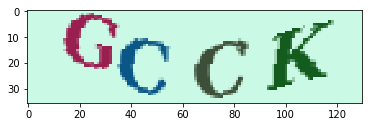

In [63]:
r = s.get("http://study.hanoi.edu.vn/getcaptcha?_=1601190563750")
soup = BeautifulSoup(r.text)
a = soup.find_all('p')[0]
image = stringToRGB(eval(a.get_text())['image'])
plt.imshow(image)
plt.show()

In [7]:
def get_predict(cookie,requesttoken,captchatime,captchainput):
    r = s.post("http://study.hanoi.edu.vn/dang-nhap?returnUrl",
               data = {'UserName' : 'avjnd', 
                       'Password' : '123456',
                       'RememberMe' : False,
                       'CaptchaTime' : captchatime,
                       'CaptchaInput' : captchainput,
                      }, 
               headers = {
                   "Cookie": cookie,
                   "RequestVerificationToken": requesttoken
               }
              )
    if ( len(r.text) == 111 ): 
        return True
    else:
        return False

In [9]:
cookie = ".AspNetCore.Antiforgery.6s6Hzu0UPcs=CfDJ8Hi2Z3swmJNFgykn1FEMmuI1J7q7lEkklAegsrc9e_GF5IzY_V9UOkyRUDQsckMdMx8JB2L8CFZZSogU2JYpdAEFVnYds9gADBHPO69iCmqeeNrAbwRWFKUjAMm5HUPHDhEKT1aoFk5d1jT8Uk6KSGw;"
requesttoken = "CfDJ8Hi2Z3swmJNFgykn1FEMmuJltoiZy1lGKHaSw12BIZMGVlnepiBcUgej_UGwOc-8AN_QI_G-rta8iCrEOFKzjmWWaHe0z7A_mPigyZiNc_NnbSGMLVb75y7NBN9aOjfmM1NiNjYgHKs962_EEZ89guI"
captchatime = eval(a.get_text())['time']
captchainput = '3WHR'
get_predict(cookie,requesttoken,captchatime,captchainput)

True

In [70]:
from tqdm import tqdm 

In [74]:
# crawl with label
count_acc = 0 
for i in tqdm(range(50000)):
    s.post('http://study.hanoi.edu.vn/getcaptcha?_=1601190563750', data = {'Name' : 'BIGipServerPool_study_hanoi_edu_vn',
                                                                       'Value' : '1814565036.20480.0000',
                                                                       'Domain' : 'study.hanoi.edu.vn',
                                                                        'Path' : '/',
                                                                       'Expires' : 'Session',
                                                                       'HttpOnly' : 'true',
                                                                       'Secure' : 'false',
                                                                      })
    r = s.get("http://study.hanoi.edu.vn/getcaptcha?_=1601190563750")
    soup = BeautifulSoup(r.text)
    a = soup.find_all('p')[0]
    image = stringToRGB(eval(a.get_text())['image'])
    # check label
    captchatime = eval(a.get_text())['time']
    get_captcha_ = get_captcha(image)
    if get_captcha_['success'] == True:
        captchainput = get_captcha_['captcha']
        if get_predict(cookie,requesttoken,captchatime,captchainput):
            image = cv2.cvtColor(np.array(image), cv2.COLOR_BGR2RGB)
            cv2.imwrite(workdir+'data/'+captchainput+'.jpg',image)
            count_acc += 1

  0%|          | 0/50000 [00:00<?, ?it/s]/home/hatto/anaconda3/lib/python3.6/site-packages/bs4/__init__.py:181: UserWarning: No parser was explicitly specified, so I'm using the best available HTML parser for this system ("lxml"). This usually isn't a problem, but if you run this code on another system, or in a different virtual environment, it may use a different parser and behave differently.

The code that caused this warning is on line 193 of the file /home/hatto/anaconda3/lib/python3.6/runpy.py. To get rid of this warning, change code that looks like this:

 BeautifulSoup(YOUR_MARKUP})

to this:

 BeautifulSoup(YOUR_MARKUP, "lxml")

  markup_type=markup_type))
 61%|██████    | 30477/50000 [1:35:40<1:01:17,  5.31it/s]


ConnectionError: ('Connection aborted.', ConnectionResetError(104, 'Connection reset by peer'))

In [73]:
print(count_acc)

829


In [64]:
get_captcha(image)

{'captcha': 'GCCK', 'success': True}

In [ ]:
plt.imshow(captcha.create('U 3 3 W'))
plt.show()